## intro 

ici on va comparer des méthodes de detection de community 

dans un notebook précédent on a determiner les parametres optimaux qu on reutilisera ici à savoir TF-IDF, k=5, τ=0.2

## chemin et import 

In [ ]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

CWD = Path.cwd()
ROOT = CWD.parent if CWD.name == "notebooks" else CWD
ARTIFACTS_DIR = ROOT / "notebooks" / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = ROOT / "data"

sys.path.insert(0, str(ROOT))
import src.graph_students as gs
import src.data_preprocessing as dp
importlib.reload(dp)
importlib.reload(gs)

MODULE = "AAA"
PRESENTATION = "2013J"
BEST = {"X": "tfidf", "k": 5, "thr": 0.2}

## reconstuire le graphe 

In [8]:
# --- load data ---
student_data, X_raw, _ = dp.load_and_prepare_oulad(
    data_dir=str(DATA_DIR),
    module=MODULE,
    presentation=PRESENTATION,
    debug=False
)

# --- build labels ---
labels_df = student_data.loc[
    (student_data["code_module"] == MODULE) &
    (student_data["code_presentation"] == PRESENTATION),
    ["id_student", "final_result"]
].copy()
labels_df["final_result"] = labels_df["final_result"].replace(
    {"Distinction": "Pass", "Withdrawn": "Fail"}
)
labels = (
    labels_df.drop_duplicates("id_student")
    .set_index("id_student")["final_result"]
    .astype(str)
)

# --- build TF-IDF matrix ---
if hasattr(dp, "tfidf_rows"):
    X_tfidf = dp.tfidf_rows(X_raw)
else:
    Xb = X_raw.copy().astype(float)
    df = (Xb > 0).sum(axis=0).replace(0, 1)
    N = Xb.shape[0]
    idf = np.log(N / df)
    Xw = Xb * idf
    row_norm = np.sqrt((Xw**2).sum(axis=1)).replace(0, 1)
    X_tfidf = Xw.div(row_norm, axis=0)

# --- build similarity + kNN graph ---
sim = gs.build_similarity_matrix(X_tfidf)
G = gs.build_knn_graph(sim, X_raw.index.tolist(),
                       k=BEST["k"], sim_threshold=BEST["thr"])

if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy() 

# --- graphe ---
n, m = G.number_of_nodes(), G.number_of_edges()
density = nx.density(G)
avg_deg = 2 * m / n
clust = nx.average_clustering(G, weight="weight")

print(f"graphe reconstruit avec TF-IDF, k={BEST['k']}, τ={BEST['thr']}")
print(f"Nodes: {n}, Edges: {m}, Density: {density:.4f}, Avg degree: {avg_deg:.2f}, Clustering: {clust:.3f}")

# --- un peu plus. dinfo---
part = gs.detect_communities(G, method="louvain")
overall_purity, _, _ = gs.compute_purity(part, labels)
print(f"Detected {len(set(part.values()))} communities, purity={overall_purity:.3f}") 

graphe reconstruit avec TF-IDF, k=5, τ=0.2
Nodes: 378, Edges: 1498, Density: 0.0210, Avg degree: 7.93, Clustering: 0.226
Detected 10 communities, purity=0.817


## test diff méthode de detection de communities

In [9]:
methods = ["louvain", "greedy", "girvan_newman"]
if gs.HAVE_IGRAPH:
    methods.append("infomap")

results_rows = []
parts = {}

print("Methods to compare:", methods)

for m in methods:
    try:
        part = gs.detect_communities(G, method=m)
        parts[m] = part
        metrics = gs.eval_partition(G, part, labels)
        metrics["method"] = m
        results_rows.append(metrics)
        print(f"{m:15s} → Q={metrics['modularity']:.3f} | k={metrics['n_communities']} | purity={metrics['purity']:.3f} | NMI={metrics['NMI']:.3f}")
    except Exception as e:
        print(f"[WARN] {m} failed:", e)

comp_df = pd.DataFrame(results_rows).sort_values(["modularity","purity"], ascending=False)
comp_df


Methods to compare: ['louvain', 'greedy', 'girvan_newman', 'infomap']
louvain         → Q=0.659 | k=10 | purity=0.817 | NMI=0.113
greedy          → Q=0.641 | k=8 | purity=0.825 | NMI=0.132
girvan_newman   → Q=0.533 | k=5 | purity=0.833 | NMI=0.152
infomap         → Q=0.627 | k=26 | purity=0.844 | NMI=0.119


,modularity,n_communities,purity,NMI,ARI,method
0,0.658520,10,0.817460,0.112520,0.057857,louvain
1,0.641056,8,0.825397,0.132012,0.080169,greedy
3,0.626974,26,0.843915,0.118881,0.039929,infomap
2,0.533215,5,0.833333,0.151511,0.143535,girvan_newman


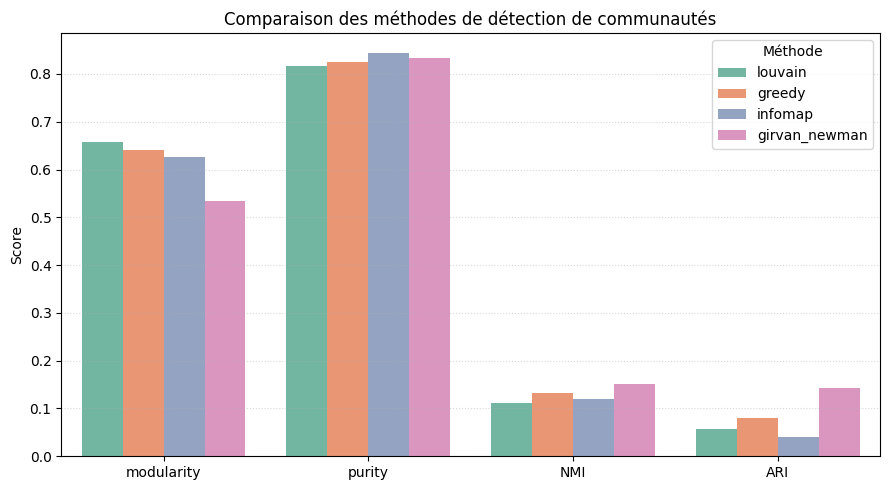

In [17]:
metrics_melted = comp_df.melt(
    id_vars="method",
    value_vars=["modularity", "purity", "NMI", "ARI"],
    var_name="Metric",
    value_name="Value"
)

order = ["louvain", "greedy", "infomap", "girvan_newman"]

plt.figure(figsize=(9,5))
sns.barplot(
    data=metrics_melted,
    x="Metric", y="Value", hue="method",
    hue_order=order,
    palette="Set2"
)
plt.title("Comparaison des méthodes de détection de communautés")
plt.ylabel("Score")
plt.xlabel("")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.legend(title="Méthode", loc="upper right")
plt.tight_layout()
plt.show()


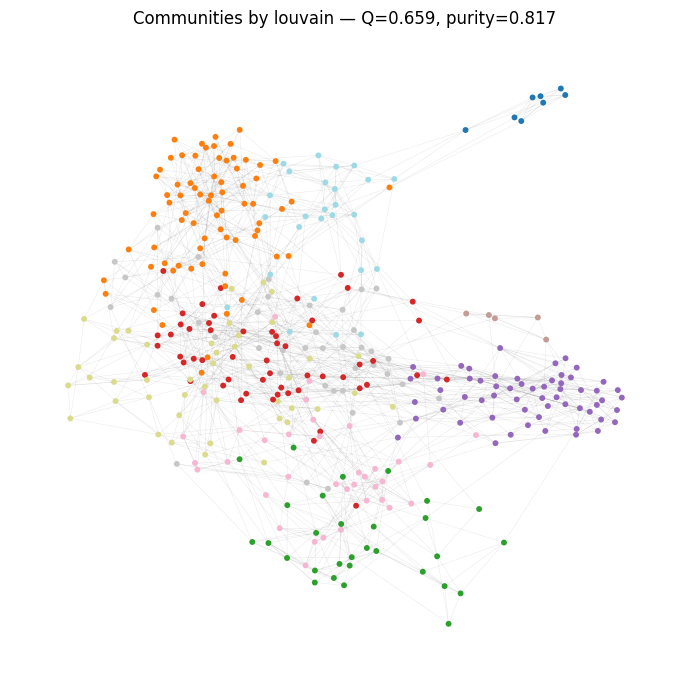

In [ ]:
# --- visualisation directe du graphe et des communautés ---
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G, seed=42)

comm_codes = pd.Series(parts[best_m]).astype("category").cat.codes

nx.draw_networkx_edges(G, pos, alpha=0.08, width=0.4)
nx.draw_networkx_nodes(
    G, pos,
    node_size=18,
    node_color=comm_codes.values,
    cmap="tab20",
    linewidths=0
)

plt.title(f"Communities by {best_m} — Q={comp_df.iloc[0]['modularity']:.3f}, purity={comp_df.iloc[0]['purity']:.3f}")
plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
part_df = pd.DataFrame.from_dict(part, orient="index", columns=["community"])
part_df.to_csv(ARTIFACTS_DIR / "partition_best.csv")

labels.to_csv(ARTIFACTS_DIR / "labels.csv")

print("Partition et labels sauvegardés dans notebooks/artifacts/")


Partition et labels sauvegardés dans notebooks/artifacts/
